# Computing MSR from fortranic spiral tip location data
Tim Tyree<br>
6.25.2022

In [4]:
from lib.my_initialization import *

In [24]:
os.chdir(nb_dir)
from lib import *

In [98]:
import seaborn as sns
import matplotlib.ticker as mtick
#reset matplotlib settings
import matplotlib as mpl
sns.reset_orig()
mpl.rc_file_defaults()

# define module

In [6]:
import re

def strip_line_to_csv(line):
    """
    Example Usage:
str_csv=strip_line_to_csv(line)
value_tuple=eval(str_csv)
    """
    str_csv=re.sub(r'\s+', ',', line.strip())
    return str_csv

In [9]:
from itertools import zip_longest
def grouper(iterable, n, fillvalue=None):
    args = [iter(iterable)] * n
    return zip_longest(*args, fillvalue=fillvalue)

 # dev of WJ's spiral tip location data for the Luo-Rudy model

In [7]:
input_folder=f"{nb_dir}/Data/from_wjr"
os.chdir(input_folder)
# input_fn_lst=os.listdir()
# input_fn=input_fnZ_lst[0]
input_fn='tippos_per_001'
input_dir=os.path.join(input_folder,input_fn)


In [10]:
#read in fortranic spiral tip locations
trial_num=0
dict_pos_lst=[]
with open(input_dir) as f:
    for lines in grouper(f, 3, ''):
        assert len(lines) == 3
        #process lines
        str_csv=strip_line_to_csv(lines[0])
        value_tuple=eval(str_csv)
        t=value_tuple[0]
        n=value_tuple[1]
        row3=value_tuple[2]
        if n>0:
            str_csv=strip_line_to_csv(lines[1])
            x_tuple=eval(str_csv)
            str_csv=strip_line_to_csv(lines[2])
            y_tuple=eval(str_csv)
            #record for each position
            for x,y in zip(x_tuple,y_tuple):
                dict_pos=dict(trial_num=trial_num,t=t,n=n,x=x-1,y=y-1) #-1 makes wj's min position 0 and max ~ width, as i have been using
                dict_pos_lst.append(dict_pos)
        else:
            trial_num+=1
df_log=pd.DataFrame(dict_pos_lst)
df_log.head()

,trial_num,t,n,x,y
0,0,1.0,6,6.6,25.8
1,0,1.0,6,27.2,63.9
2,0,1.0,6,59.6,199.8
3,0,1.0,6,60.8,2.6
4,0,1.0,6,127.5,199.3


In [16]:
#DONE: save as .csv
log_dir=os.path.abspath(input_fn)+'_log.csv'
df_log.to_csv(log_dir,index=False)

In [25]:
#TODO: modify run_routine_log_to_unwrapped_trajectory to output traj here and take df_log
#input: df_log
#output: traj
run_routine_log_to_unwrapped_trajectory

<function lib.routines.dag_log_to_msd.run_routine_log_to_unwrapped_trajectory(input_file_name, sr, mem, L, use_cache, DS=0.025, **kwargs)>

In [36]:
#TODO: determine width and height of the computational domain input the discretization
DS=0.025
DT=1.
ds=DS*width #cm for the whole domain
width,height=df_log.describe().loc['max'][['x','y']].values.T
printing=True
if printing:
    print(df_log.describe().loc[['min','max']][['x','y']])
    print(f"{width=},{height=}")

         x      y
min    0.0    0.0
max  200.0  200.0
width=200.0,height=200.0


In [37]:
#TODO: compute spiral tip trajectories, as before
tmin=df_log['t'].min()
sr=3*width
mem=0
groups=df_log.groupby(by='trial_num')

In [45]:
task_lst=[]
for trial_num,g in groups:
    #TODO: for each group, g
    pass
    task_lst.append(g)

In [47]:
#TODO: find the mem, sr, that i used before
#TODO: generate tip tracks using pbc
traj = compute_track_tips_pbc(g, mem=mem, sr=sr, width=width, height=height)
#test max times agree
assert g['t'].max()==traj['t'].max()
##HINT:
# log_dir=os.path.abspath(input_fn)+'_log.csv'
# df_loc.to_csv(log_dir,index=False)

Frame 92: 1 trajectories present.


In [54]:
#TODO: compute the lifetimes
pid_col='particle'
t_col='t'
#print summary stats on particle lifetimes for one input folder
dft=traj.groupby(pid_col)[t_col].describe()
df_lifetimes=-dft[['max','min']].T.diff().loc['min']
print(f"termination time was {traj[t_col].max():.2f} ms")
print(f"printing summary stats on particle lifetimes:")
print(df_lifetimes.describe())
# print(df_lifetimes.head(10))
print("\nPlease make a manual decision about minimum_lifetime, crop_start_by, and crop_end_by")

termination time was 93.00 ms
printing summary stats on particle lifetimes:
count    16.000000
mean     17.062500
std      24.076181
min      -0.000000
25%       0.750000
50%       6.000000
75%      21.250000
max      59.000000
Name: min, dtype: float64

Please make a manual decision about minimum_lifetime, crop_start_by, and crop_end_by


In [59]:
#src: http://localhost:8890/notebooks/Processing%20a%20Folder%20of%20Tip%20Logs.ipynb
#TODO: see what happens when i turn this off
#TODO: see what happens when i turn other things off
minimum_lifetime=300. #ms
crop_start_by=0#40
crop_end_by=150#40
df_lifetime.head()

True

In [64]:
# unwrap_trajectories
jump_thresh=np.min((width,height))/2
pid_lst = sorted(set(traj[pid_col].values))

In [74]:
jump_thresh=190

In [79]:
#unwrap trajectories indexed by pid_col
round_t_to_n_digits=7
df_traj = pd.concat([unwrap_traj_and_center(traj[traj[pid_col]==pid].copy(), width, height, DS) for pid in pid_lst])
df_traj[t_col] = df_traj[t_col].round(round_t_to_n_digits)
df_traj.head()

,trial_num,t,n,x,y,frame,particle
2481435,640,1.0,12,0.0,0.0,0,0
2481436,640,1.0,12,0.0,0.0,0,1
2481437,640,1.0,12,0.0,0.0,0,2
2481448,640,2.0,8,0.0,-199.2,1,2
2481456,640,3.0,6,0.0,-398.3,2,2


In [87]:
# df_traj[df_traj['frame']==0]
def FlowerPlot(df_traj,pid_lst,**kwargs):
    pass

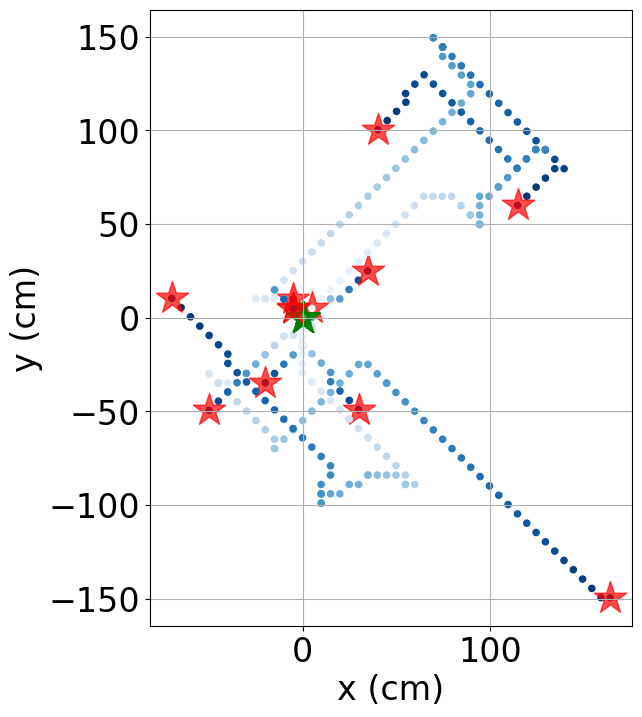

In [99]:
c_col="t"
width=200
height=200
fontsize=24
DS = 5/200
DT=1.
alpha=1
cmap="Blues"

fig, ax = plt.subplots(figsize=(8,8))
for pid in  pid_lst:#[2:]:
    x_values ,y_values, c_values = df_traj[(df_traj.particle==pid)][['x','y', c_col]].values.T.copy()
    #scale to real coords
    x_values *= DS
    y_values *= DS
    plt.scatter(x_values,y_values, s=20,#s=0.1
                c=c_values, vmin = np.min(c_values), vmax = np.max(c_values), cmap=cmap,alpha=alpha)#, **kwargs)
    plt.scatter([x_values[0]],[y_values[0]], s=600,color='green',marker='*',alpha=0.7)
    plt.scatter([x_values[-1]],[y_values[-1]], s=600,color='red',marker='*',alpha=0.7)
# format_plot
ax.set_xlabel('x (cm)', fontsize=fontsize)
ax.set_ylabel('y (cm)', fontsize=fontsize)
# We change the fontsize of minor ticks label
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.tick_params(axis='both', which='minor', labelsize=0)
ax.grid('on')
ax.set_aspect('equal')
plt.show()
#heretim

In [91]:
# ax=PlotFlowerTrajectories(df,col="t",width=200,height=200,fontsize=24,DS = 5/200, DT=1., jump_thresh=10., alpha=0.01,saving = False, savefig_folder=None,savefig_fn=None, chop_at_first_jump = True, ax=None,cmap="Blues")#, **kwargs)

In [80]:
#DONT: truncate trajectories to their first apparent jump (pbc jumps should have been removed already)
# df = pd.concat([unwrap_traj_and_center(traj[traj[pid_col]==pid].copy(), width, height, DS) for pid in pid_lst])
# #truncate trajectories to their first apparent jump (pbc jumps should have been removed already)
# df_lst = []
# for pid in  pid_lst:#[2:]:
#     d = df[(df.particle==pid)].copy()
#     x_values, y_values = d[['x','y']].values.T
#     index_values = d.index.values.T
#     jump_index_array, spd_lst = find_jumps(x_values, y_values, 
#                                            width=width, height=height, 
#                                            DS=DS,DT=DT, jump_thresh=jump_thresh)#, **kwargs)#.25)
#     if len(jump_index_array)>0:
#         print(f"jump for {pid=}!  {np.max(spd_lst)=:.4f}")
# #         ji = jump_index_array[0]
# #         d.drop(index=index_values[ji:], inplace=True)
#     df_lst.append(d)
# df_traj = pd.concat(df_lst)
# df_traj['t'] = df_traj.t.round(round_t_to_n_digits)

In [76]:
df_traj.head()

#WARNING: particles appear to be jumping by over 190 distance units (pixels).
#TODO: root cause analysis as to why i am getting jumps in the unwrapped trajectories

,trial_num,t,n,x,y,frame,particle
2481435,640,1.0,12,0.0,0.0,0,0
2481436,640,1.0,12,0.0,0.0,0,1
2481437,640,1.0,12,0.0,0.0,0,2
2481448,640,2.0,8,0.0,-199.2,1,2
2481456,640,3.0,6,0.0,-398.3,2,2


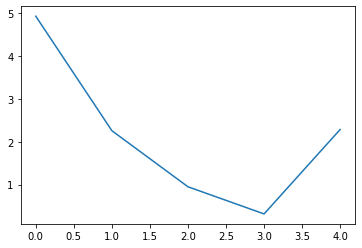

In [70]:
plt.plot(spd_lst)

In [69]:
pid_set_values=np.unique(traj['particle'].values)
pid_set_values.shape

(16,)

In [ ]:
tavg1=4#8#4 #moving average window, in ms

# tavg2=12#24 #ms #savgol_filter time window performed on R 
tavg2=24# #ms #savgol_filter time window performed on R  #12 ms was no longer smooth
# tavg2=10.# #ms #savgol_filter time window performed on R  #12 ms was no longer smoothd

In [ ]:
#TODO: copy pro

In [20]:
traj_lst=[]
trial_num_lst=[]
df_annihilations_lst=[]

NameError: name 'pandas' is not defined

In [ ]:
#TODO: find annihilation pairs, as before
#TODO: compute df_annihilations, as before
# #TODO: save as .csv
##HINT:
# log_dir=os.path.abspath(input_fn)+'_log.csv'
# df_loc.to_csv(log_dir,index=False)

In [ ]:
#option 1: high level with the same smoothing, as before
# #TODO: compute msr_values from df_annihilations, as before, with smoothing
# #HINT: dfr is made in here:
# dfr_dir=routine_compute_radial_velocities_pbc_cu(input_fn,
#                                                  tavg2,
#                                                  width,  #for handling periodic boundary conditions (pbc)
#                                                  height, #for handling periodic boundary conditions (pbc)
#                                                  ds,     #domain size in cm.  set to width to have nulled effect
#                                                  max_dtmax_thresh = 0,      #ms
#                                                  max_Rfinal_thresh = 0.2,   #cm
#                                                  min_duration_thresh = 40,  #ms
#                                                  round_t_to_n_digits=7,
#                                                  trial_col='event_id_int',
#                                                  pid_col=pid_col,
#                                                  t_col='t',
#                                                  use_tavg2=True,
#                                                  save_df_pairs=True,
#                                                  printing=True,
#                                                  testing=True)#,**kwargs)
    

#     df=pd.read_csv(dfr_dir)

In [ ]:
# #GOAL: compute the msr_values simply without any kind of smoothing, and plot with the computed msr_values
# # option 1: turn off smoothing in generation of df
# # option 2: implement it fresh
# #TODO: compute the R_values,tau_values simply without any kind of smoothing, and plot with the computed msr_values
# # #TODO: compute smoothed msr, as before
# R_lst=[]
# tau_lst=[]
# for d in df_annihilations.iterrows():
#     pass
# #for each row of df_annihilations, compute subtract_pbc  


# #HINT: subtract the values
# # #HINT for subtracting two points
# # subtract_pbc=get_subtract_pbc(width=width,height=height)
# # w=subtract_pbc(point,segment[0])



# bins=np.arange(0,2000)
# tau_values=0.5*(bins[:-1]+bins[1:])
# #TODO: bin and bootstrap dfr, as before

In [28]:
#TODO: plot the two methods of computing msr_values. compare. share with WJ.

In [ ]:
# TODO(bonus): FlowerPlot the trajectories before/after smoothing
#HINT: unwrap traj, as before
# #HINT for unwrapping trajectories
# pid_lst = sorted(set(df[pid_col].values))
# #(duplicates filtered earlier_ _  _ _ ) filter_duplicate_trajectory_indices is slow (and can probs be accelerated with a sexy pandas one liner)
# pid_lst_filtered = pid_lst#filter_duplicate_trajectory_indices(pid_lst,df)
# # pid_lst_filtered = filter_duplicate_trajectory_indices(pid_lst,df)
# df = pd.concat([unwrap_traj_and_center(df[df[pid_col]==pid], width, height, DS, **kwargs) for pid in pid_lst_filtered])